In [1]:
#pip install requests beautifulsoup4 pandas nltk textblob wordcloud gensim matplotlib seaborn scikit-learn

In [2]:
#pip install scipy==1.10.1

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import nltk
import scipy

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
scipy.linalg.triu


C:\Users\User\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\User\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


<function scipy.linalg._special_matrices.triu(m, k=0)>

# Download NLTK stopwords

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Scrape Reviews From Skytrax

In [5]:
def scrape_skytrax_reviews(url, max_pages=5):
    reviews = []
    
    for page in range(1, max_pages + 1):
        response = requests.get(url + f'page/{page}/')
        if response.status_code != 200:
            print(f"Failed to retrieve page {page}")
            continue
        
        soup = BeautifulSoup(response.text, 'html.parser')
        review_blocks = soup.find_all('div', class_='text_content')  # Adjust class if needed
        
        for review in review_blocks:
            reviews.append(review.text.strip())
    
    return reviews

In [6]:
url = "https://www.airlinequality.com/airline-reviews/malaysia-airlines/"  
reviews = scrape_skytrax_reviews(url, max_pages=10)

In [7]:
df = pd.DataFrame(reviews, columns=['review'])
df.to_csv("skytrax_reviews.csv", index=False)

In [8]:
print(f"Scraped {len(reviews)} reviews.")

Scraped 100 reviews.


In [9]:
df.head(10)

,review
0,✅ Trip Verified | Vegetarian meals were serv...
1,✅ Trip Verified | Selected vegetarian meals ...
2,✅ Trip Verified | Check in at KLIA was quick...
3,✅ Trip Verified | The cabin crew on my recen...
4,✅ Trip Verified | I had an extremely disappo...
5,✅ Trip Verified | Check in at Penang quick a...
6,✅ Trip Verified | Check in at LHR T4 was qui...
7,✅ Trip Verified | Kuala Lumpur to Kuching re...
8,✅ Trip Verified | At the time of booking my ...
9,"✅ Trip Verified | Amazing airline, the bigge..."


# Function for Text Cleaning

In [10]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()  
    # Remove numbers
    text = re.sub(r'\d+', '', text)  
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text) 
    # Tokenize text
    tokens = word_tokenize(text)  
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')] 
    return " ".join(tokens)

In [11]:
# Cleaning
df['cleaned_review'] = df['review'].apply(clean_text)
df.head(10)

,review,cleaned_review
0,✅ Trip Verified | Vegetarian meals were serv...,trip verified vegetarian meals served requeste...
1,✅ Trip Verified | Selected vegetarian meals ...,trip verified selected vegetarian meals flight...
2,✅ Trip Verified | Check in at KLIA was quick...,trip verified check klia quick found new busin...
3,✅ Trip Verified | The cabin crew on my recen...,trip verified cabin crew recent malaysia airli...
4,✅ Trip Verified | I had an extremely disappo...,trip verified extremely disappointing experien...
5,✅ Trip Verified | Check in at Penang quick a...,trip verified check penang quick easy small qu...
6,✅ Trip Verified | Check in at LHR T4 was qui...,trip verified check lhr quick easy minimal que...
7,✅ Trip Verified | Kuala Lumpur to Kuching re...,trip verified kuala lumpur kuching return feb ...
8,✅ Trip Verified | At the time of booking my ...,trip verified time booking flight paid extra f...
9,"✅ Trip Verified | Amazing airline, the bigge...",trip verified amazing airline biggest thing fr...


In [12]:
df.to_csv("cleaned_reviews.csv", index=False)

# Sentiment Analysis

In [13]:
df['polarity'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment'] = df['polarity'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

In [14]:
df['sentiment'].value_counts()

sentiment
Positive    68
Negative    30
Neutral      2
Name: count, dtype: int64

# Plot Sentiment Distribution


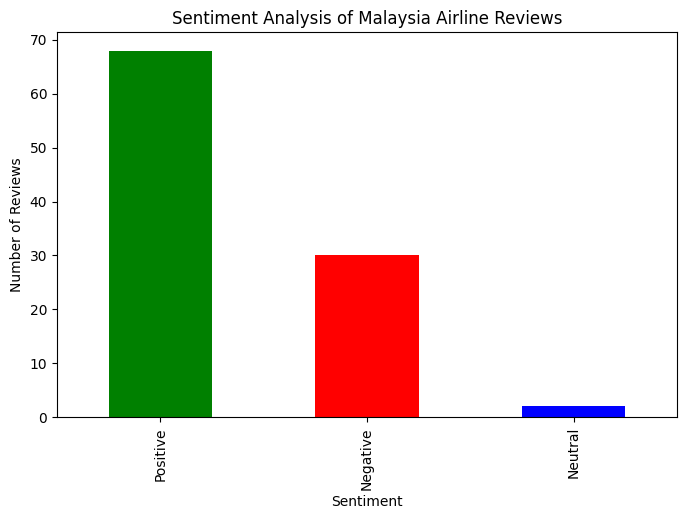

In [15]:
plt.figure(figsize=(8, 5))
df['sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
plt.title("Sentiment Analysis of Malaysia Airline Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

# Extract Frequent Positive & Negative Words

In [16]:
sia = SentimentIntensityAnalyzer()

In [17]:
# Define stopwords
stop_words = set(stopwords.words("english"))

In [18]:
# Extract sentiment words
def extract_frequent_words(text_list, sentiment="pos"):
    words = []
    for text in text_list:
        tokens = word_tokenize(text.lower())  # Tokenize
        filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove stopwords
        words.extend(filtered_tokens)

    # Score words individually using SentimentIntensityAnalyzer
    sentiment_words = []
    for word in words:
        score = sia.polarity_scores(word)["compound"]
        if sentiment == "pos" and score > 0.2:
            sentiment_words.append(word)
        elif sentiment == "neg" and score < -0.2:
            sentiment_words.append(word)

    # Count most frequent words
    return [word for word, _ in Counter(sentiment_words).most_common(10)]

In [19]:
# Get frequent positive and negative words
positive_words = extract_frequent_words(df["cleaned_review"], sentiment="pos")
negative_words = extract_frequent_words(df["cleaned_review"], sentiment="neg")

print("Frequent Positive Words:", positive_words)
print("Frequent Negative Words:", negative_words)

Frequent Positive Words: ['good', 'entertainment', 'well', 'friendly', 'great', 'excellent', 'like', 'help', 'delicious', 'comfortable']
Frequent Negative Words: ['delayed', 'cancelled', 'lost', 'bad', 'poor', 'worst', 'terrible', 'disappointing', 'delay', 'rude']


# Generate Word Cloud

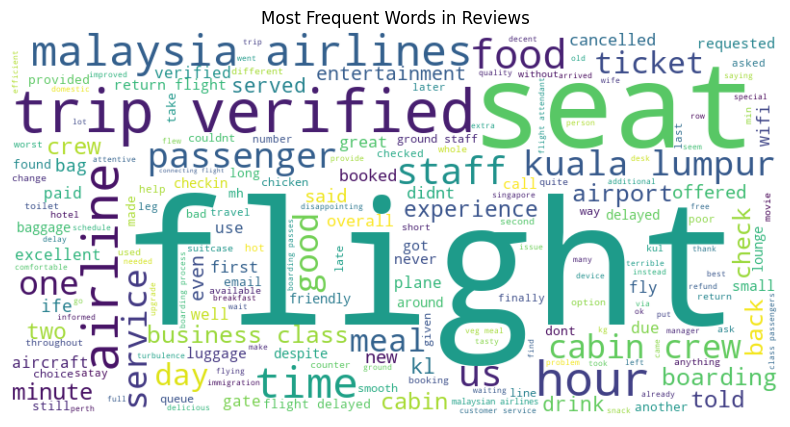

In [20]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df['cleaned_review']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Reviews")
plt.show()

# Topic Modeling with LDA

In [21]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['cleaned_review'])

# Convert to dictionary format for LDA
dictionary = corpora.Dictionary([text.split() for text in df['cleaned_review']])
corpus = [dictionary.doc2bow(text.split()) for text in df['cleaned_review']]

lda_model = models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)
topics = lda_model.print_topics(num_words=5)

In [22]:
print("\n### Topic Modeling Results ###")
for topic in topics:
    print(topic)


### Topic Modeling Results ###
(0, '0.028*"flight" + 0.013*"verified" + 0.012*"trip" + 0.010*"crew" + 0.008*"seats"')
(1, '0.021*"flight" + 0.013*"airlines" + 0.011*"malaysia" + 0.009*"verified" + 0.008*"back"')
(2, '0.029*"flight" + 0.013*"trip" + 0.013*"verified" + 0.009*"airlines" + 0.009*"cabin"')
